In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190705.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190705"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)
    
pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

# # Save standards to file
# stds_out = pd.concat(QC, stds)
# stds['rundate'] = meas_day
# stds.to_csv("../processed_data/RVT_Autosampler_StdConcentrations.txt", mode='a', sep="\t", index=False, header=False, na_rep='NaN')
# print(stds_out)

                           sample  N2O_peak  CO2_peak  CH4_peak        ppm
0     CH4Std_100ppm_742019_32.txt     44015   1585486    128250    100.000
1      CH4Std_10ppm_742019_14.txt     37731   7570304     15591     10.000
2       CH4Std_2ppm_742019_13.txt     48194    652004    507660      2.000
3    CH4Std_5030ppm_742019_33.txt     30771   1162807   7429830   5030.000
4   CO2Std_10100ppm_742019_44.txt     23327  20401726         0  10100.000
5     CO2Std_1010ppm_742019_7.txt     35211   2506955         0   1010.000
6   CO2Std_50000ppm_742019_45.txt     23421  84400447      2958  50000.000
7      CO2Std_500ppm_742019_6.txt     24971   1417988         0    500.000
78   N2OStd_0101ppm_742019_20.txt     66143    710171      4077      0.101
79     N2OStd_05ppm_742019_21.txt     91082    472041      4767      0.500
80     N2OStd_10ppm_742019_59.txt    735950    981326      3969     10.000
81      N2OStd_1ppm_742019_22.txt    328134    328650      2899      1.000
82     N2OStd_80ppm_74201

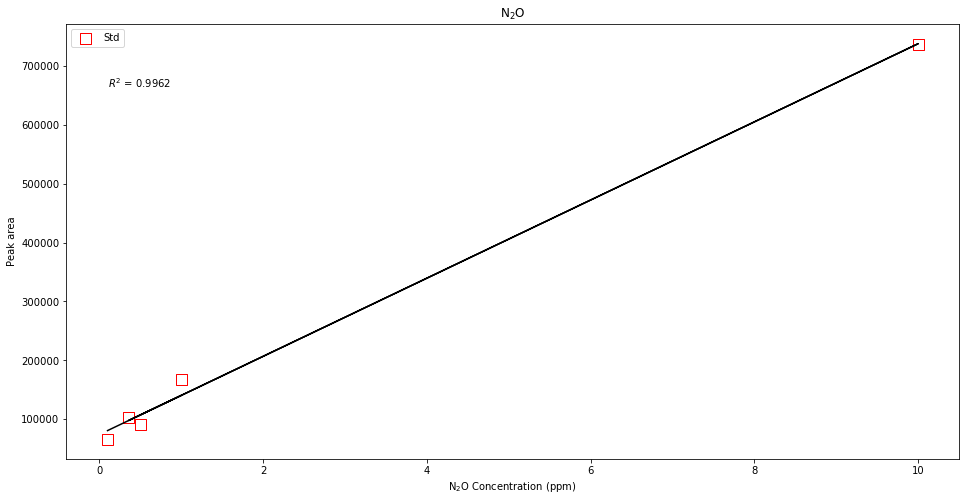

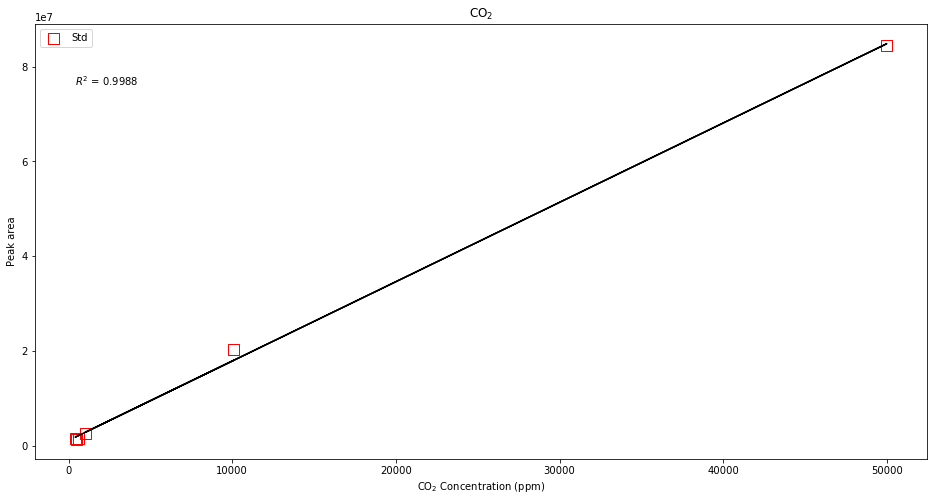

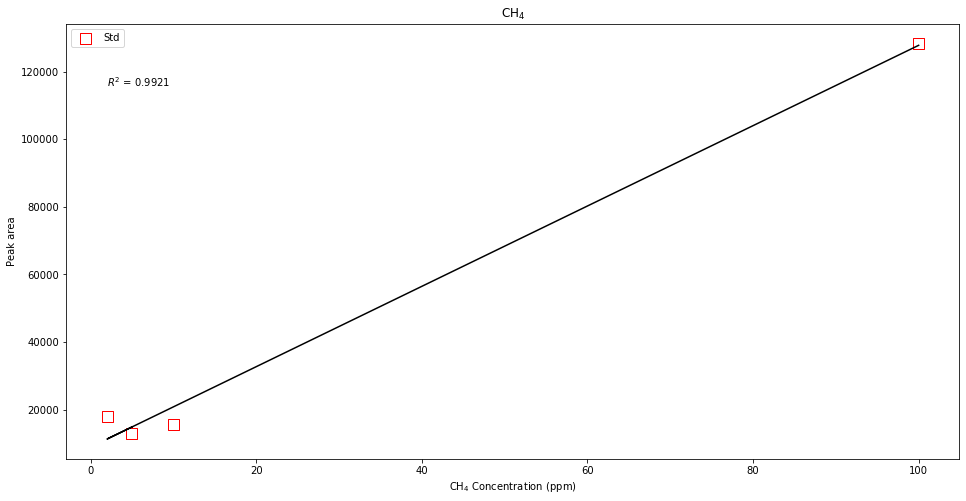

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Get indices of QCs
i = QC.index[QC['sample'] == 'QC-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm_742019_88.txt']
j = QC.index[QC['sample'] == 'QC-CO2Std_605ppm-CH4Std_5ppm-N2O_1ppm.txt']

# Played around with CH4 standard curve -- low values (<10 ppm) seem unreliable
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std[~CH4std['sample'].str.contains('_2ppm')] # 2ppm looks absurdly high
CH4std = CH4std.append({'ppm': 2., 'CH4_peak': QC.loc[i, 'CH4_peak'].values[0]}, ignore_index=True)
CH4std = CH4std.append({'ppm': 5., 'CH4_peak': QC.loc[j, 'CH4_peak'].values[0]}, ignore_index=True)

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_80ppm')] # Drop 80 ppm since no samples are above 10 ppm
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_1ppm')] # Drop 1 ppm as well -- based on previous days, it may be high
N2Ostd = N2Ostd.append({'ppm': 0.36, 'N2O_peak': QC.loc[i, 'N2O_peak'].values[0]}, ignore_index=True)
N2Ostd = N2Ostd.append({'ppm': 1.0, 'N2O_peak': QC.loc[j, 'N2O_peak'].values[0]}, ignore_index=True)

# Play around with CO2 standard curve
CO2std = CO2std.append({'ppm': 400, 'CO2_peak': QC.loc[i, 'CO2_peak'].values[0]}, ignore_index=True)
CO2std = CO2std.append({'ppm': 605, 'CO2_peak': QC.loc[j, 'CO2_peak'].values[0]}, ignore_index=True)

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],r'CO$_2$')
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],r'CH$_4$')

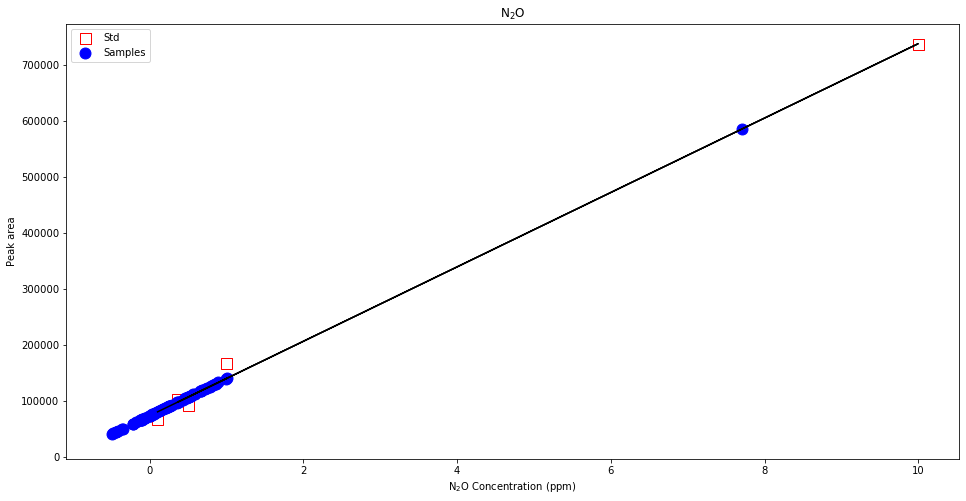

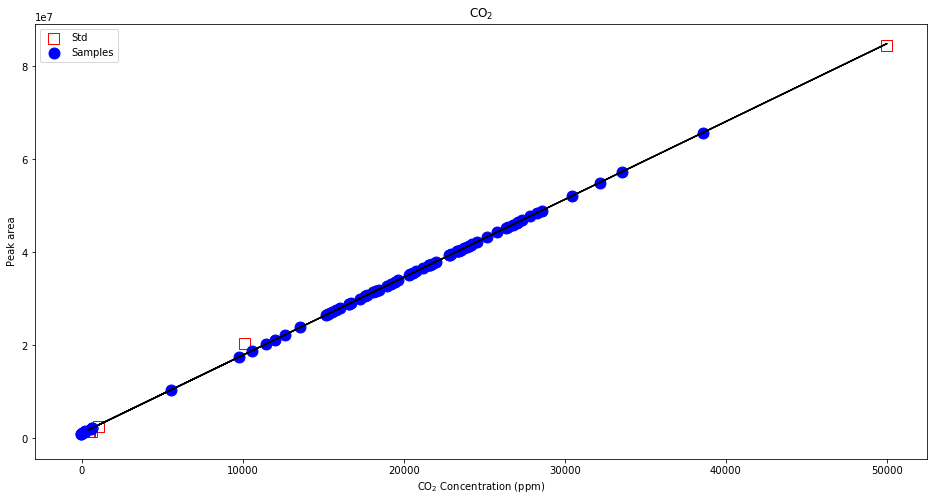

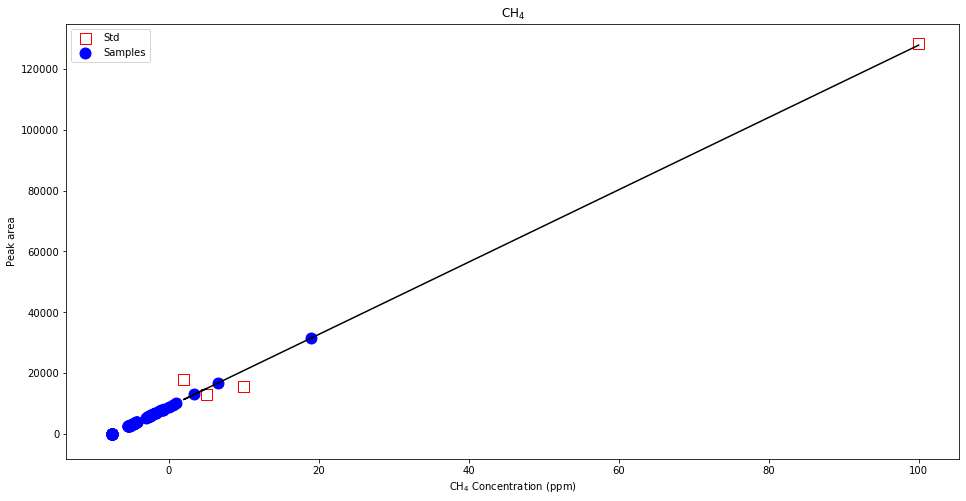

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [7]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190705.txt", 
                                 write_to_datafile=True)
print(saveoutput)

   vial    location depth       date method    dup  N2O_conc  N2O_bdl  \
8    40  Atmosphere     0 2019-05-16      G  False  0.050500     True   
9    28  Atmosphere     0 2019-05-24      G  False  0.050500     True   
10   87  Atmosphere     0 2019-06-17      G  False  0.050500     True   
11    4        NTC1   110 2019-05-15      G  False  0.258704    False   
12   64        NTC1   110 2019-05-24      G  False  0.146931    False   
13    5        NTC1   140 2019-05-15      H  False  0.050500     True   
14   65        NTC1   140 2019-05-24      H  False  0.050500     True   
15    1        NTC1    20 2019-05-15      G  False  0.116665    False   
16   61        NTC1    20 2019-05-24      G  False  0.262709    False   
17    2        NTC1    50 2019-05-15      G  False  0.050500     True   
18   62        NTC1    50 2019-05-24      G  False  0.219915    False   
19    3        NTC1    80 2019-05-15      G  False  0.288774    False   
20   63        NTC1    80 2019-05-24      G  False 